In [ ]:
conda install tensorflow

done
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
WARNING conda.models.version:get_matcher(556): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
WARNING conda.models.version:get_matcher(556): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.6.0.*, but conda is ignoring the .* and treating it as 1.6.0
done
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



| 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



| 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



- 

In [ ]:
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras import Model, Input, metrics
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import backend
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
%load_ext tensorboard
from tensorboard import notebook
import datetime,os
import numpy as np


from metrics.intersection_over_union import iou
from pooling_layers.max_pooling import MaxPoolingWithArgmax2D
from pooling_layers.max_unpooling import MaxUnpooling2D
from data_processing import prepare_data

In [9]:
pip install -U scikit-learn scipy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 30.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 16.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 33.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove

In [3]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
def conv_block_3(input_tensor, kernel_size, filters, stage, block):
    """Conv block.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    if input_tensor.shape[3] ==filters3:
        shortcut = input_tensor
    else:
        shortcut = layers.Conv2D(filters3, (1, 1))(input_tensor)
        
    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [3]:
def identity_block_3(input_tensor, kernel_size, filters, stage, block, next_layer_filter):
    """Identity block
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        next_layer_filter: in segnet previous mask will be added to unpool, 
        need to make sure they have same number of filters
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    if input_tensor.shape[3] ==filters3:
        shortcut = input_tensor
    else:
        shortcut = layers.Conv2D(filters3, (1, 1))(input_tensor)
        
    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    if x.shape[3]!=next_layer_filter:
        x=layers.Conv2D(next_layer_filter, (1, 1))(x)
    return x

In [4]:
def SegNet(input_shape, batch_size, n_labels=2, kernel=3, pool_size=(2, 2), output_mode="softmax", model_summary=None):
    # encoder
    inputs = Input(shape=input_shape, batch_size=batch_size)
    conv_1=conv_block_3(input_tensor=inputs, kernel_size=(kernel,kernel), filters=[64,64,64],stage=1, block='a')
    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_1)
    conv_2=conv_block_3(input_tensor=pool_1, kernel_size=(kernel,kernel), filters=[128,128,128], stage=2, block='a')
    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_2)
    conv_3=conv_block_3(input_tensor=pool_2, kernel_size=(kernel,kernel), filters=[128,128,128], stage=3, block='a')
    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_3)
    conv_4=conv_block_3(input_tensor=pool_3, kernel_size=(kernel,kernel), filters=[256,256,256], stage=4, block='a')
    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_4)
    conv_5=conv_block_3(input_tensor=pool_4, kernel_size=(kernel,kernel), filters=[256,256,256], stage=5, block='a')
    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_5)
    print("Build enceder done..")
    

    # decoder
    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])
    conv_6=identity_block_3(input_tensor=unpool_1, kernel_size=(kernel,kernel), filters=[256,256,256], stage=6, block='a', next_layer_filter=256)
    unpool_2 = MaxUnpooling2D(pool_size)([conv_6, mask_4])
    conv_7=identity_block_3(input_tensor=unpool_2, kernel_size=(kernel,kernel), filters=[256,256,256], stage=7, block='a', next_layer_filter=128)
    unpool_3 = MaxUnpooling2D(pool_size)([conv_7, mask_3])
    conv_8=identity_block_3(input_tensor=unpool_3, kernel_size=(kernel,kernel), filters=[128,128,128], stage=8, block='a', next_layer_filter=128)
    unpool_4 = MaxUnpooling2D(pool_size)([conv_8, mask_2])
    conv_9=identity_block_3(input_tensor=unpool_4, kernel_size=(kernel,kernel), filters=[128,128,128], stage=9, block='a', next_layer_filter=64)
    unpool_5 = MaxUnpooling2D(pool_size)([conv_9, mask_1])
    conv_10=identity_block_3(input_tensor=unpool_5, kernel_size=(kernel,kernel), filters=[64,64,64], stage=10, block='a', next_layer_filter=64)

    out=layers.Conv2D(n_labels,1, activation = output_mode)(conv_10)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=out, name="SegNet")
    model.compile(optimizer = optimizers.Adam(lr = 1e-3), loss = 'categorical_crossentropy',metrics=[iou,'accuracy'])

    if model_summary is True:
        model.summary()

    return model

In [ ]:
tb = TensorBoard(log_dir='training_logs/test_log1', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='trained_models/test1.h5', monitor='iou', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='min', monitor='val_loss', patience=50, verbose=1)
callbacks = [tb, mc, es]
batch_size = 16
model=SegNet(input_shape=(256, 256, 3), batch_size=batch_size, n_labels=2, model_summary=True)
num_epochs = 25
model.fit(prepare_data.train_data_generator(batch_size=16),
                    validation_data=prepare_data.validation_data_generator(batch_size=16),epochs=num_epochs, 
                    verbose=1,steps_per_epoch=246, validation_steps=84,callbacks=callbacks)

In [ ]:
model=SegNet(input_shape=(256, 256, 3),batch_size=16, n_labels=2, model_summary=True)
model.load_weights('trained_models/seg_resnet_1.h5')
result=model.evaluate(prepare_data.test_data_generator(batch_size=16),steps=85)
print(result)

Build enceder done..
Build decoder done..
Model: "SegNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(16, 256, 256, 3)]  0                                            
__________________________________________________________________________________________________
res1a_branch2a (Conv2D)         (16, 256, 256, 64)   256         input_2[0][0]                    
__________________________________________________________________________________________________
bn1a_branch2a (BatchNormalizati (16, 256, 256, 64)   256         res1a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_30 (Activation)      (16, 256, 256, 64)   0           bn1a_branch2a[0][0]              
___________________________________________________

Found 1360 images belonging to 2 classes.
Found 1360 images belonging to 2 classes.


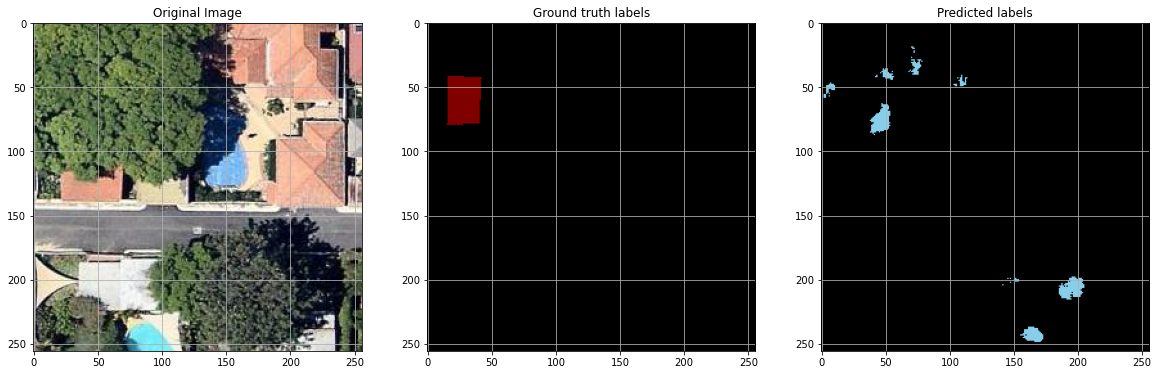

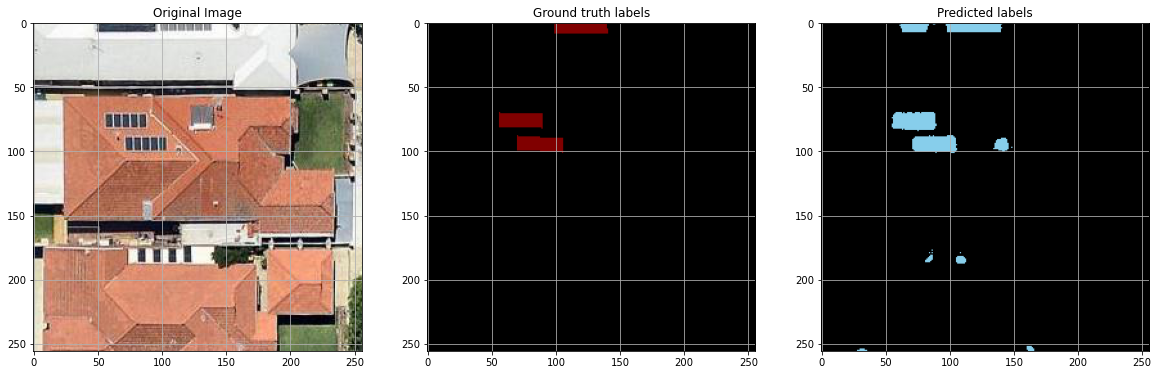

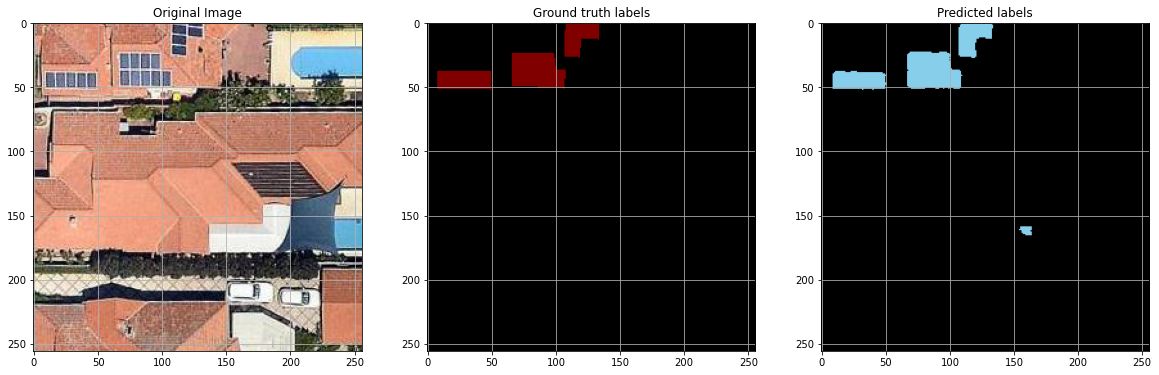

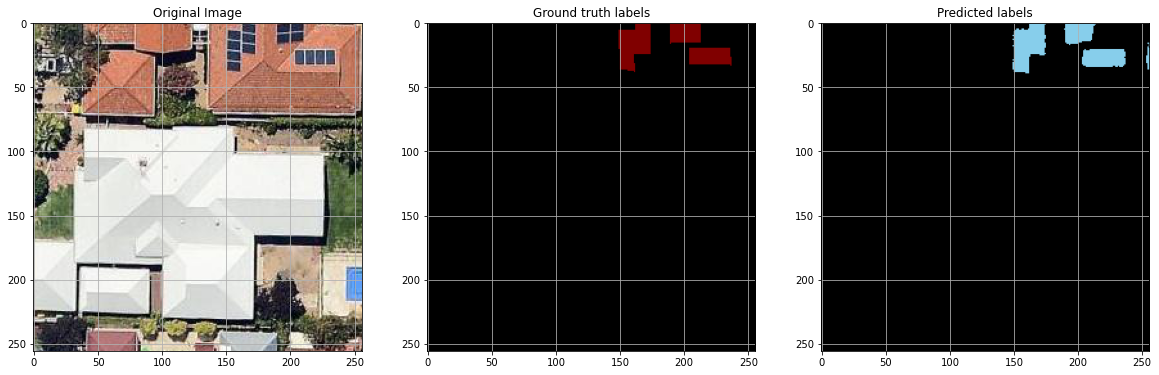

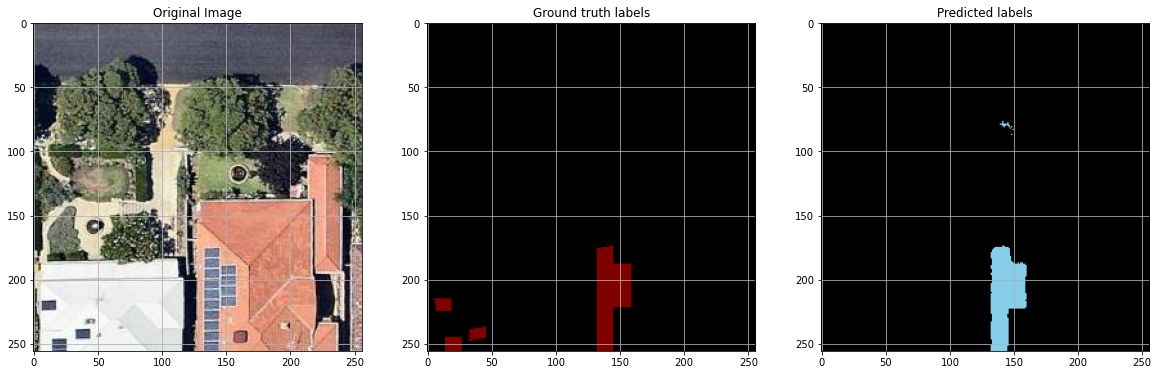

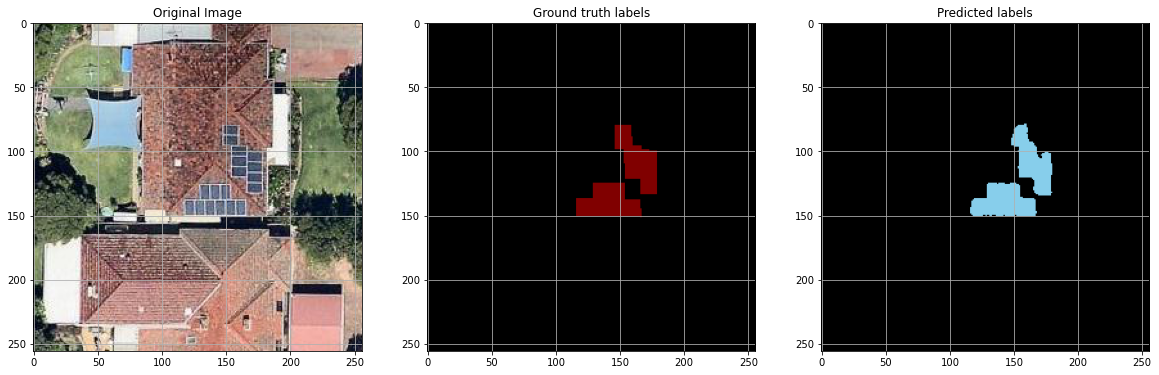

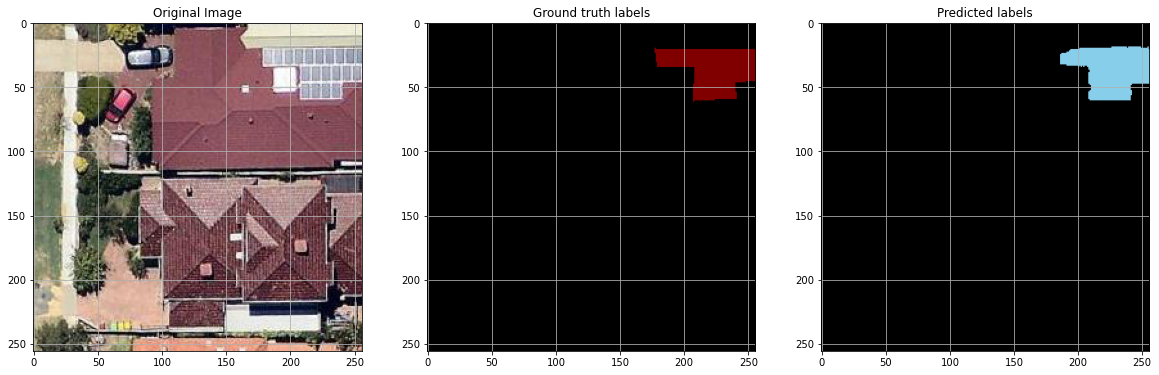

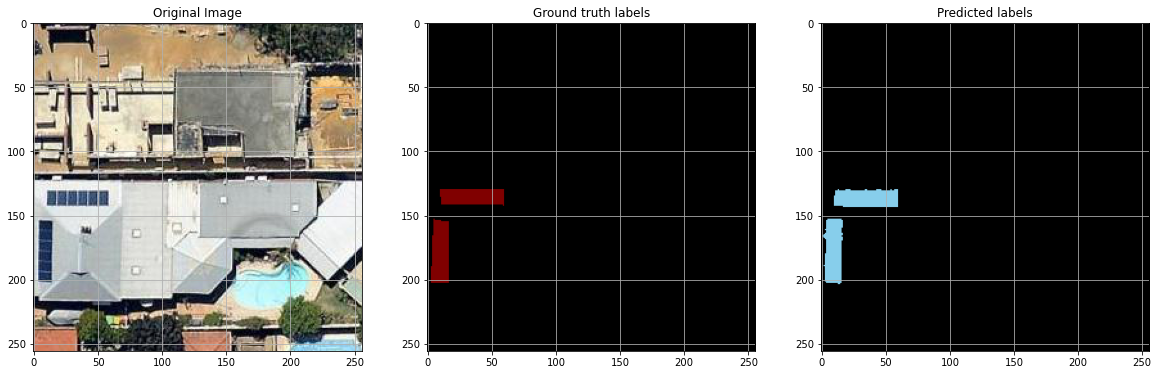

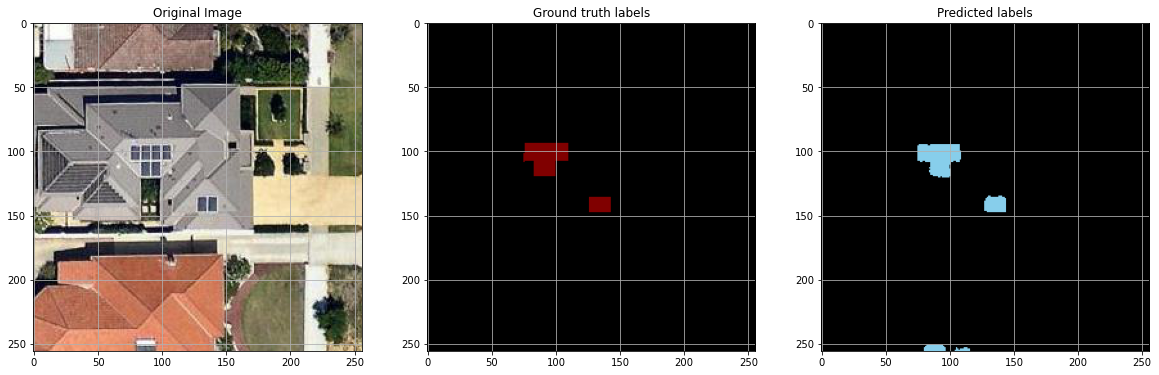

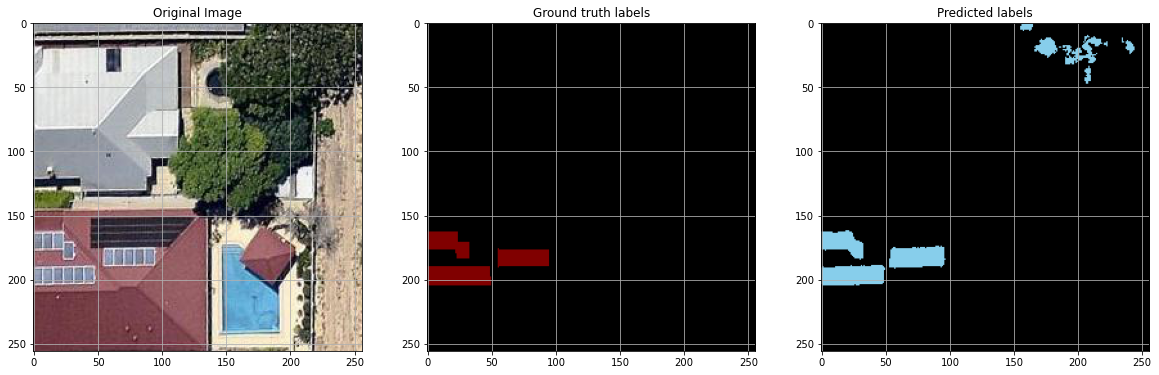

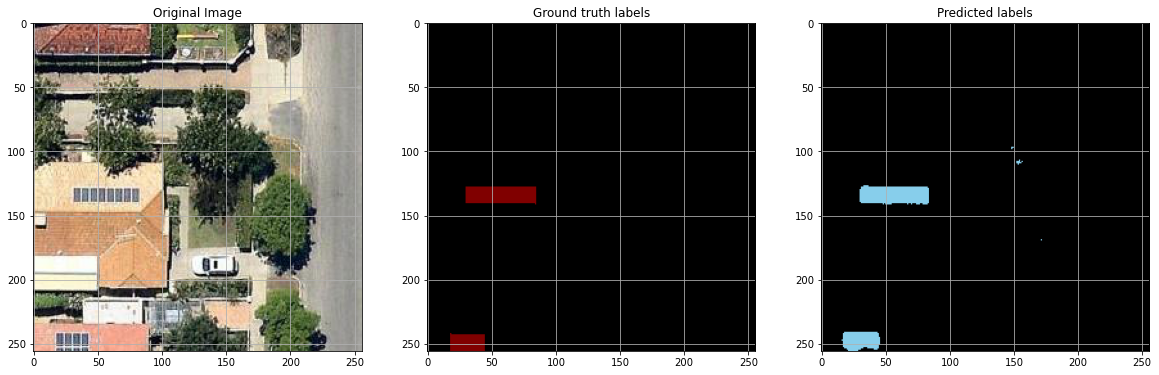

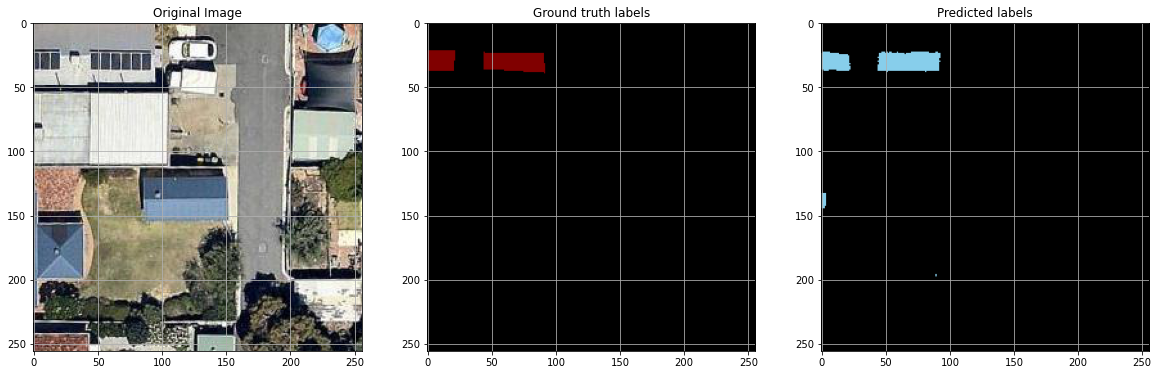

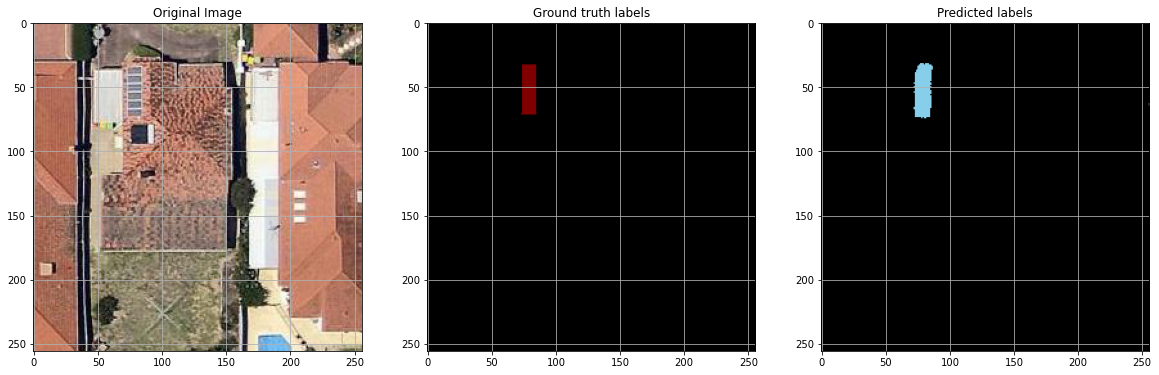

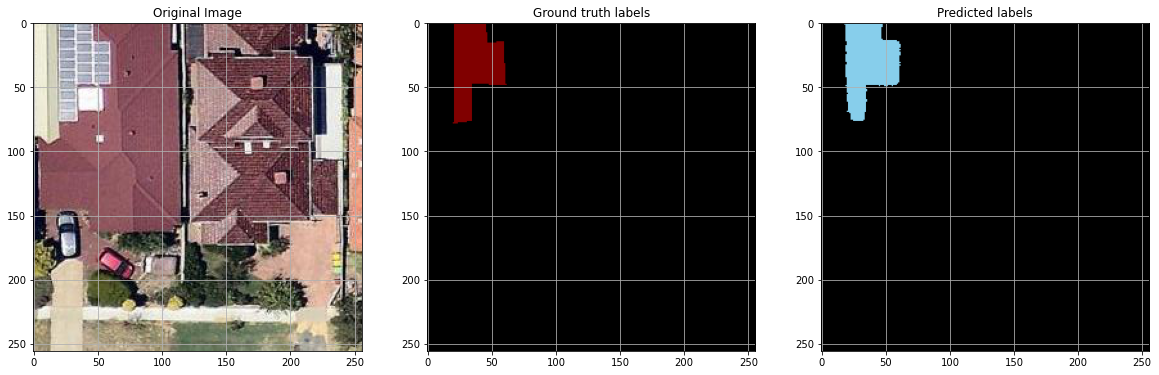

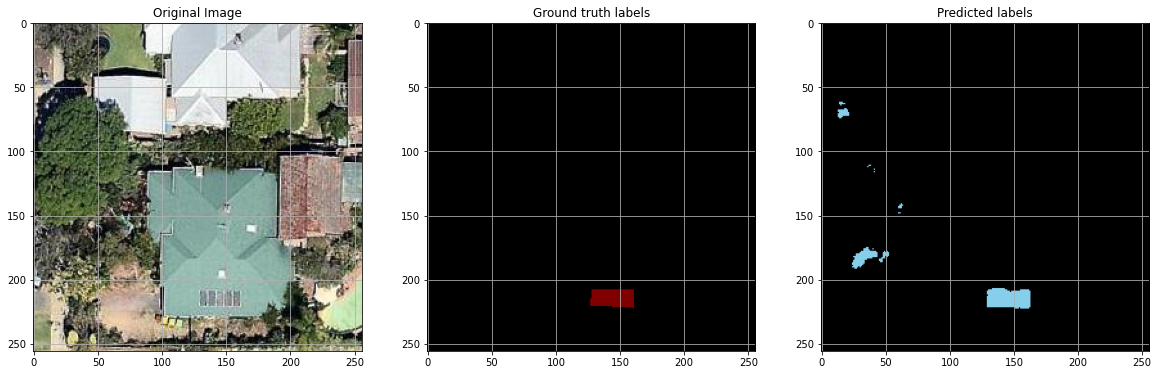

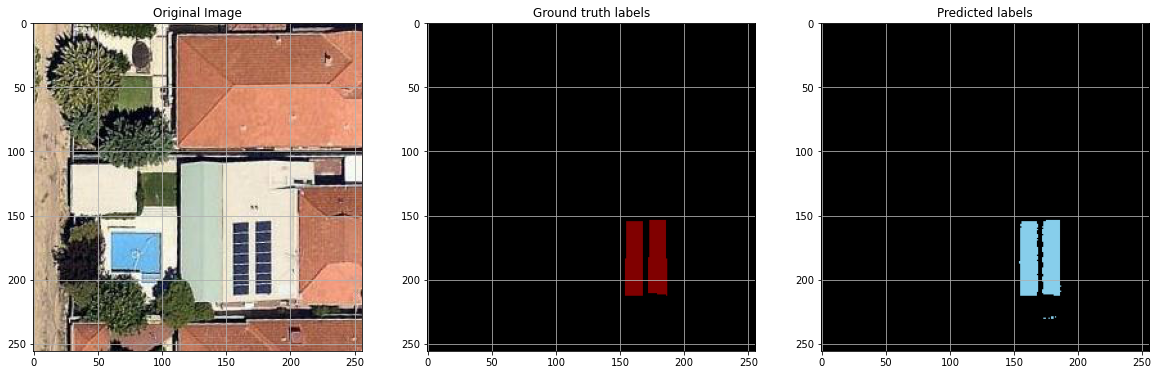

In [6]:
model=SegNet(input_shape=(256, 256, 3), batch_size=16, n_labels=2, model_summary=True)
model.load_weights('trained_models/seg_resnet_1.h5')
flag=1
testing_gen = prepare_data.test_data_generator(batch_size=16, seed=20)
#testing_gen=PrepareData.images_without_label_data_generator(batch_size=16)
while(flag>0):
    flag=flag-1
    batch_img, batch_mask= next(testing_gen)
    #batch_img = next(testing_gen)
    pred_all = model.predict(batch_img)
    np.shape(pred_all)

    for i in range(0, np.shape(pred_all)[0]):
        fig = plt.figure(figsize=(20, 8))

        ax1 = fig.add_subplot(1, 3, 1)
        ax1.imshow(batch_img[i])
        ax1.title.set_text('Original Image')
        ax1.grid(b=None)

        ax2 = fig.add_subplot(1, 3, 2)
        ax2.set_title('Ground truth labels')
        ax2.imshow(prepare_data.onehot_to_rgb(batch_mask[i], prepare_data.id2code))
        ax2.grid(b=None)

        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_title('Predicted labels')
        #Use a different color for prediction
        new_color_code={0: (0, 0, 0), 1: (135,206,235)}
        ax3.imshow(prepare_data.onehot_to_rgb(pred_all[i], new_color_code))
        ax3.grid(b=None)
        plt.show()

In [ ]:
%tensorboard --logdir training_logs/logs14
#!tensorboard --logdir /tmp/whatever